# Final asignment: Food informer

#### Am I paying too much for groceries?

## Loading libraries


In [1]:
from FoodInformer import FoodInformer as fi

import yaml

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp

## Reading in the configuration file

In [2]:
def get_config(config_file):
    with open(config_file, 'r') as stream:
        config = yaml.safe_load(stream)
    return config

In [3]:
config = get_config(config_file="config_file.yaml")

## Reading the NEVO database
Het Nederlandse Voedselbestand (NEVO) Is a curated list made by the RIVM, comprised of common Dutch food with corestponding ingredients, marcro and micro nutrients.

In [4]:
nevo = pd.read_csv(filepath_or_buffer=config["data_files"]["NEVO"],
                   sep='|', header=0, index_col=0, decimal=',')
nevo_details = pd.read_csv(filepath_or_buffer=config["data_files"]["NEVO_DETAILS"],
                   sep='|', header=0, index_col=0, decimal=',')

## Exploritory Data inspection
As we can see, our data is divided under 146 columns and 2323 rows. However, not all of these entries are going to be taken into consideration. Only the name, macro nutrients, processed sugar, fibre and sodium content will be taken into the next part of the analysis.

In [5]:
print(nevo.shape, '\n')
print(nevo.info(), '\n')
print(list(nevo.columns))

(2323, 146) 

<class 'pandas.core.frame.DataFrame'>
Index: 2323 entries, NEVO-Online 2023 8.0 to NEVO-Online 2023 8.0
Columns: 146 entries, Voedingsmiddelgroep to FAUN (g)
dtypes: float64(134), int64(3), object(9)
memory usage: 2.6+ MB
None 

['Voedingsmiddelgroep', 'Food group', 'NEVO-code', 'Voedingsmiddelnaam/Dutch food name', 'Engelse naam/Food name', 'Synoniem', 'Hoeveelheid/Quantity', 'Opmerking', 'Bevat sporen van/Contains traces of', 'Is verrijkt met/Is fortified with', 'ENERCJ (kJ)', 'ENERCC (kcal)', 'WATER (g)', 'PROT (g)', 'PROTPL (g)', 'PROTAN (g)', 'NT (g)', 'TRP (mg)', 'FAT (g)', 'FACID (g)', 'FASAT (g)', 'FAMSCIS (g)', 'FAPU (g)', 'FAPUN3 (g)', 'FAPUN6 (g)', 'FATRS (g)', 'CHO (g)', 'SUGAR (g)', 'STARCH (g)', 'POLYL (g)', 'FIBT (g)', 'ALC (g)', 'OA (g)', 'ASH (g)', 'CHORL (mg)', 'NA (mg)', 'K (mg)', 'CA (mg)', 'P (mg)', 'MG (mg)', 'FE (mg)', 'HAEM (mg)', 'NHAEM (mg)', 'CU (mg)', 'SE (µg)', 'ZN (mg)', 'ID (µg)', 'VITA_RAE (µg)', 'VITA_RE (µg)', 'RETOL (µg)', 'CARTBTOT (µg)

In [6]:
nevo = nevo[['Voedingsmiddelgroep', 'Voedingsmiddelnaam/Dutch food name', 'ENERCC (kcal)', 'PROT (g)', 'FAT (g)', 'SUGAR (g)', 'FIBT (g)', 'NA (mg)']]

## Inspect data and see if there are any missing values.
This dataset stores floating-point numbers using `,` as a decimal. Instead of the American way of using the `.` as decimal. If this is not passed on pandas, the value will be read as a `string`. The latter has been accounted for as all of the floating point values are correctly loaded as a `float64`-type. Furthermore, there are some missing values. I assess the dataset to be large enough to drop these missing values. Another option would've been to insert a `0` as a replacement value. This could be true because there are food-products which do not contain any fibre, sodium or sugar. However, making assumptions can be tricky and it forgoes my knowledge of food and nutrition.

In [7]:
print(nevo.info())
print(nevo.isna().sum())

nevo = nevo.dropna()

<class 'pandas.core.frame.DataFrame'>
Index: 2323 entries, NEVO-Online 2023 8.0 to NEVO-Online 2023 8.0
Data columns (total 8 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Voedingsmiddelgroep                 2323 non-null   object 
 1   Voedingsmiddelnaam/Dutch food name  2323 non-null   object 
 2   ENERCC (kcal)                       2323 non-null   int64  
 3   PROT (g)                            2323 non-null   float64
 4   FAT (g)                             2323 non-null   float64
 5   SUGAR (g)                           2322 non-null   float64
 6   FIBT (g)                            2316 non-null   float64
 7   NA (mg)                             2321 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 163.3+ KB
None
Voedingsmiddelgroep                   0
Voedingsmiddelnaam/Dutch food name    0
ENERCC (kcal)                         0
PROT (g)                 

## Dimensionality reduction by Principal Component Analysis (PCA)
Even though the dataset has been reduced by an order of magnitude. It is still difficult to get a feeling for how the food groups are represented. For instance, how similar is fruit to vegetable? Or is there an unhealthy group containing lots of fat and sodium. By reducing the demensionality of the dataframe and plotting the two largest eigenvectors will help us get a feeling for the data and decide the next steps of the analysis.

### Getting the right lables
The first step of the demensionality reduction, is done by getting the lables of each foodgroup. It is important to maintain the order of the dataframe and the food lables. Switching either of these up, will misrepresent our data further downstream.

In [8]:
food_labels = nevo["Voedingsmiddelgroep"]
food_labels == nevo["Voedingsmiddelgroep"]

NEVO-versie/NEVO-version
NEVO-Online 2023 8.0    True
NEVO-Online 2023 8.0    True
NEVO-Online 2023 8.0    True
NEVO-Online 2023 8.0    True
NEVO-Online 2023 8.0    True
                        ... 
NEVO-Online 2023 8.0    True
NEVO-Online 2023 8.0    True
NEVO-Online 2023 8.0    True
NEVO-Online 2023 8.0    True
NEVO-Online 2023 8.0    True
Name: Voedingsmiddelgroep, Length: 2313, dtype: bool

### Scaling the data
Some of the features have way higher values than others. This can mess up your representation by overrepresentation. To combat this, a normalisation will have to be performed on all of the numerical entries.

In [9]:
from sklearn.preprocessing import StandardScaler

# features to be scaled
features = ['ENERCC (kcal)', 'PROT (g)', 'FAT (g)', 'SUGAR (g)', 'FIBT (g)', 'NA (mg)']

#features = ["PROT (g)", "ENERCC (kcal)"]

# Separating out the features
nevo_f_values = nevo[features].values
nevo_scaled = StandardScaler().fit_transform(nevo_f_values)

In [10]:
nevo_scaled.shape

(2313, 6)

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
p_components = pca.fit_transform(nevo_scaled)
p_components = pd.DataFrame(data=p_components, columns=["P1", "P2"])

For the last step of the PCA wel'll add back the food groups.

In [12]:
p_components["food_group"] = list(nevo["Voedingsmiddelgroep"])

### Two dimentional plot of the two larges components
Plotting the two largest eigen vectors on y- and x-axis reveals a symetry where `P2 < 0` contain mostly starch/sugar containing foods. Above the threshold of `P2 > 0` the majority of oily and protein rich food groups can be observed. However, due to the high amount of food groups, it is still difficult to observe the underlying structure.

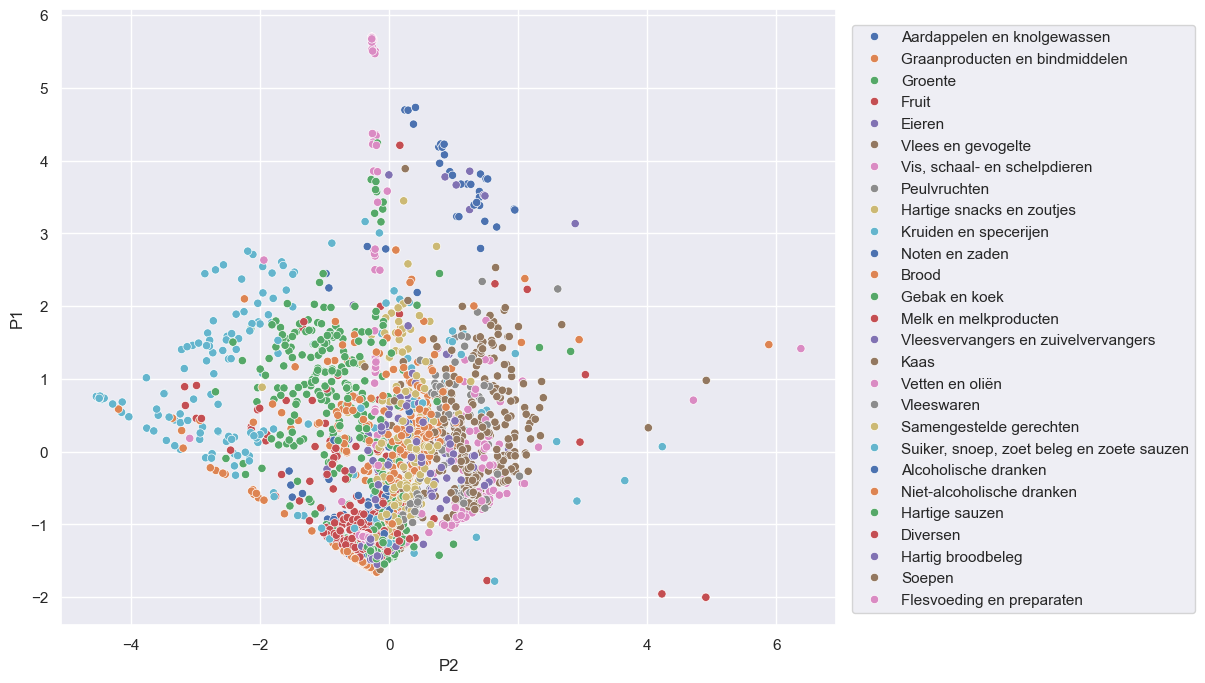

In [13]:
sns.set(rc={"figure.figsize":(10, 8)})
sns.scatterplot(data=p_components, x="P2", y="P1", hue="food_group", palette="deep")
plt.legend(bbox_to_anchor=(1.001, 1), loc='upper left', borderaxespad=1)

## Subsetting for simplicity
For the scope of this project, a subset of non-snack foods will be taken. Also, drinks, spices, combined meals and `Overige` will be excluded. This is done as this project will be about saving money and eating well. The excluded food groups can be concidered as a luxury or processed.

In [14]:
food_subset = ['Aardappelen en knolgewassen', 'Graanproducten en bindmiddelen',
       'Groente', 'Fruit', 'Eieren', 'Vlees en gevogelte',
       'Vis, schaal- en schelpdieren', 'Peulvruchten',
       'Noten en zaden', 'Brood',
       'Melk en melkproducten', 'Vleesvervangers en zuivelvervangers',
       'Kaas', 'Vetten en oliën', 'Vleeswaren', 'Hartig broodbeleg']

nevo = nevo[nevo["Voedingsmiddelgroep"].isin(food_subset)]

### Re-running the PCA and visualisation

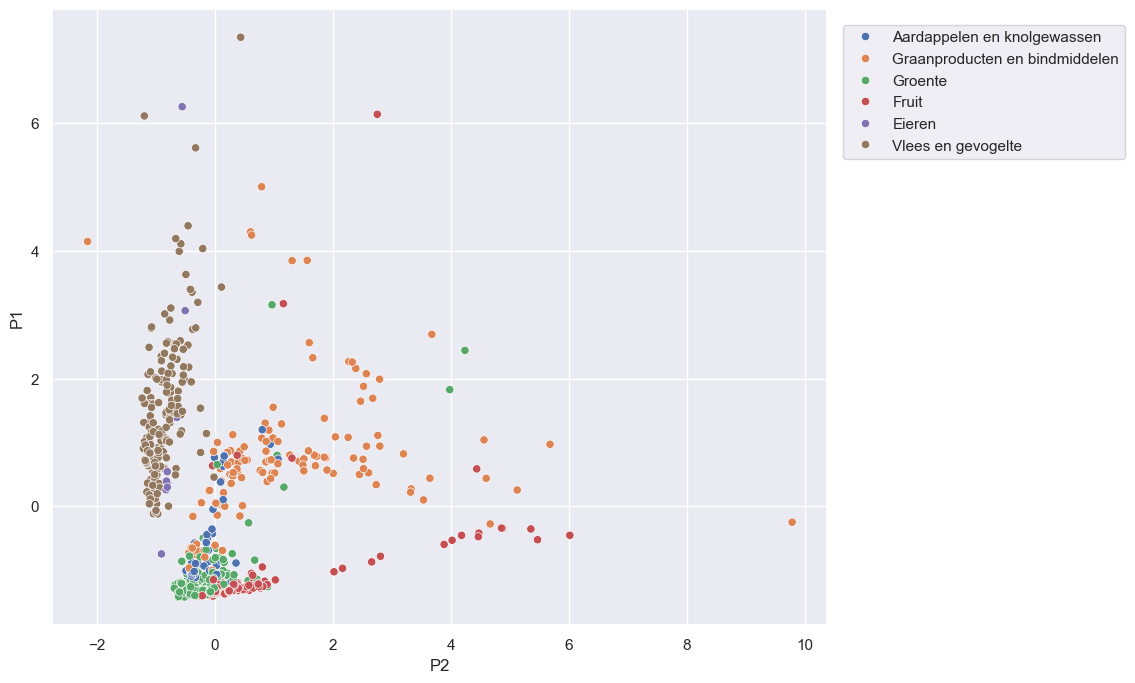

In [15]:
# Separating out the features
def PCA_food_group(food_group=food_subset, dataset=nevo):
    if type(food_group) == str:
        food_group=[food_group]
    dataset = dataset[dataset["Voedingsmiddelgroep"].isin(food_group)]
    nevo_f_values = dataset[features].values
    nevo_scaled = StandardScaler().fit_transform(nevo_f_values)
    pca = PCA(n_components=2)
    p_components = pca.fit_transform(nevo_scaled)
    p_components = pd.DataFrame(data=p_components, columns=["P1", "P2"])
    p_components["food_group"] = list(dataset["Voedingsmiddelgroep"])
    sns.set(rc={"figure.figsize":(10, 8)})
    sns.scatterplot(data=p_components, x="P2", y="P1", hue="food_group", palette="deep")
    plt.legend(bbox_to_anchor=(1.001, 1), loc='upper left', borderaxespad=1)

PCA_food_group(['Aardappelen en knolgewassen', 'Groente', 'Fruit', 'Graanproducten en bindmiddelen','Eieren', 'Vlees en gevogelte'])

Above we can see the 